# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [26]:
import numpy as np
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy
import os
import torch
from sys import platform
from utilities import *

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier

from DrTorch.metrics import F1_Score_Multi_Labels
from models.bertFull import BertFull


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting the device

In [27]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [28]:
if device != 'mps':
    !nvidia-smi


Thu Feb 22 16:15:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.70                 Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   44C    P8               4W /  75W |    405MiB /  8188MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [29]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

BERT_DIRECTORY = "local-bert"

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

In [30]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Taking a look to same utterance example

In [31]:
display_utterance(dataframe=df, utterance_id='utterance_6')
display_utterance(dataframe=df, utterance_id='utterance_456')
display_utterance(dataframe=df, utterance_id='utterance_2005')


Utterance 6


,speakers,emotions,utterances,triggers
0,Joey,surprise,But then who? The waitress I went out with las...,0.0
1,Rachel,sadness,You know? Forget it!,0.0
2,Joey,surprise,"No-no-no-no, no! Who, who were you talking about?",0.0
3,Rachel,fear,"No, I-I-I-I don't, I actually don't know",0.0
4,Joey,neutral,Ok!,1.0
5,Joey,neutral,"All right, well...",1.0
6,Rachel,neutral,"Yeah, sure!",0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Removing NaN Values

In [32]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Analyzing the dataset

In [33]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in an utterance: {speakers['min_speakers']}")
print(f"Maximum number of speakers in an utterance: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in an utterance: {utterances['length_min']}")
print(f"Maximum number of sentences in an utterance: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in an utterance: 1
Maximum number of speakers in an utterance: 8

Minimum number of sentences in an utterance: 2
Maximum number of sentences in an utterance: 24


In [34]:
produce_emotion_distribution_for_speakers(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


In [35]:
train_df, val_df, test_df = split_dataset(df)

display(train_df.head())
display(val_df.head())
display(test_df.head())


,speakers,emotions,utterances,triggers
index,,,,
utterance_3440,"[Phoebe, Phoebe, The Smoking Woman, Phoebe, Th...","[neutral, anger, neutral, anger, anger, anger,...","[Oh. Oh! Ma'am? Excuse me, ma'am?, You can't p...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
utterance_1475,"[Joey, Ross, Emily, Liam, Emily, Liam, Liam, R...","[neutral, neutral, neutral, surprise, joy, joy...","[No., You'll see., Liam, do me a favour. Tell ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
utterance_2342,"[Rachel, Phoebe, Rachel, Phoebe, Rachel, Rachel]","[neutral, neutral, surprise, neutral, sadness,...","[Phoebe?, Yeah?, Look at that guy by the windo...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
utterance_214,"[Joey, Rachel, Joey, Dina, Dina, Dina, Bobby, ...","[disgust, sadness, anger, fear, fear, neutral,...","[One pregnant woman at a time, please! I just ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_910,"[Phoebe, Phoebe, Monica, Phoebe, Monica, Phoeb...","[joy, joy, joy, joy, neutral, joy, neutral, jo...","[Oh, great!, We couldn't keep our eyes off eac...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


,speakers,emotions,utterances,triggers
index,,,,
utterance_1938,"[Joey, Joey, Joey]","[neutral, neutral, sadness]",[There will come a time in each of your career...,"[0.0, 0.0, 1.0]"
utterance_1596,"[All, Joey, Phoebe, Joey, Phoebe, Joey, Phoebe...","[joy, neutral, neutral, neutral, neutral, joy,...","[Pheebs! Hey Pheebs!, Uh, okay, Pheebs?, Yeah?...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3248,"[Ross, Phoebe, Ross, Phoebe, Ross, Phoebe, Ros...","[neutral, anger, sadness, anger, sadness, joy,...","[By the way, the week before your wedding you ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_131,"[Rachel, Rachel, Rachel, Ross, Rachel, Ross]","[neutral, neutral, neutral, joy, neutral, neut...","[Okay umm, Ross?, I'm-I'm really warm, so I'm ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_3388,"[Joey, Chandler, Monica, Joey, Chandler, Joey,...","[neutral, disgust, sadness, joy, joy, neutral,...","[So, did you uh, find anyone to marry you guys...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."


,speakers,emotions,utterances,triggers
index,,,,
utterance_837,"[Rachel, Danny, Rachel, Danny, Rachel, Monica,...","[surprise, joy, neutral, neutral, neutral, neu...","[Hey! Oh right, tonight was your party., Oh wo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_370,"[Kristen, Ross, Kristen, Ross, Kristen, Ross, ...","[joy, neutral, surprise, joy, neutral, neutral...","[Umm, this is great wine., It's from France In...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2018,"[Hoshi, Hoshi]","[neutral, joy]","[You are iron., You are steel!]","[0.0, 0.0]"
utterance_2361,"[Ross, Joey, Ross, Joey, Ross, Joey, Ross, Joe...","[neutral, neutral, neutral, neutral, joy, neut...",[Well obviously only one of us can keep dating...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_1904,"[Ross, Kristin, Ross, Kristin]","[neutral, joy, neutral, surprise]",[I'm just sayin' if dogs do experience jet lag...,"[0.0, 0.0, 1.0, 0.0]"


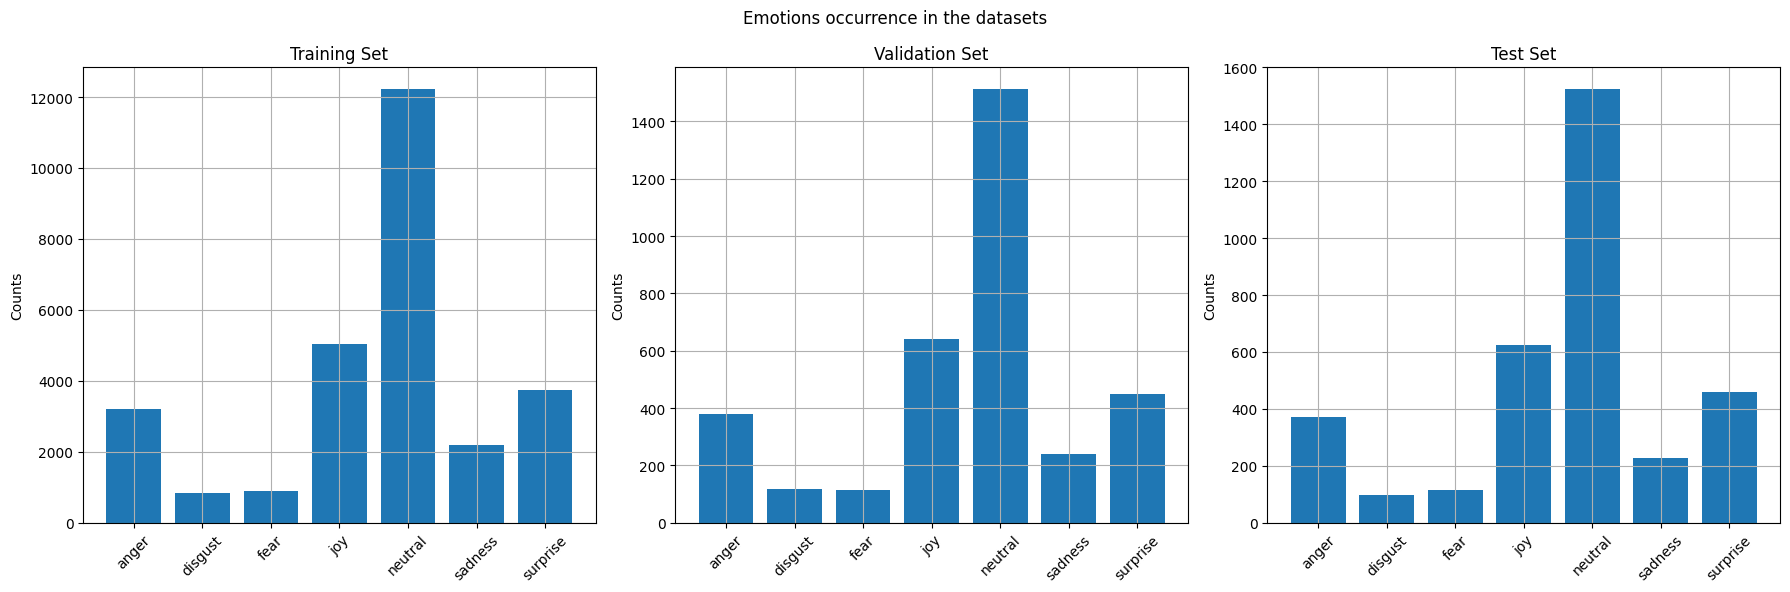

In [36]:
plot_emotion_distribution(train_df, val_df, test_df)


## Random Classifier

In [37]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona

new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
"""display_utterance(dataframe=new_test_df, utterance_id=0)    """

TypeError: can only concatenate str (not "int") to str

## Majority Classifier

In [38]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
"""display_utterance(dataframe=new_test_df, utterance_id=0)"""


TypeError: can only concatenate str (not "int") to str

## Bert Models

In [39]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
EMOTIONS_TO_INT = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
INT_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

print("Aaahhh le emozioni: ", EMOTIONS)

Aaahhh le emozioni:  ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']


In [40]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY)


In [41]:
from DrTorch.utilities import DataLoaderFromPipelineStrategy

def construct_input(data_sample):
    tokenizer = BertTokenizer.from_pretrained("local-bert")
    
    tokenized_dialog = [tokenizer.cls_token]
    for utterance in data_sample:
        tokenized_dialog += tokenizer.tokenize(utterance) + [tokenizer.sep_token]
    
    return tokenized_dialog

dataLoaderBuilder = DataLoaderFromPipelineStrategy()
dataloader = dataLoaderBuilder.create(train_df[["utterances", "speakers"]], train_df[["emotions", "triggers"]], shuffle=True)


In [56]:
dialogs = [
    [
    "also I was the point person on my company's transition from the KL-5 to GR-6 system.",
    "You must've had your hands full.",
    "That I did. That I did.",
    "So let's talk a little bit about your duties.",
    "My duties? All right."
    ],
    ["cacca", "caccona"]
]

tokens = []
# Preparazione dell'input
for dialog in dialogs:
    tokens.append(construct_input(dialog))

# Converti in ID e tronca se necessario
input_ids = bert_tokenizer.convert_tokens_to_ids(tokens)[:512]  # Assicurati di non superare il limite di 512 token

input_ids_tensor = torch.tensor([input_ids])
print(np.shape(input_ids_tensor))
print(bert_tokenizer.sep_token)


[['[CLS]',
  'also',
  'i',
  'was',
  'the',
  'point',
  'person',
  'on',
  'my',
  'company',
  "'",
  's',
  'transition',
  'from',
  'the',
  'k',
  '##l',
  '-',
  '5',
  'to',
  'gr',
  '-',
  '6',
  'system',
  '.',
  '[SEP]',
  'you',
  'must',
  "'",
  've',
  'had',
  'your',
  'hands',
  'full',
  '.',
  '[SEP]',
  'that',
  'i',
  'did',
  '.',
  'that',
  'i',
  'did',
  '.',
  '[SEP]',
  'so',
  'let',
  "'",
  's',
  'talk',
  'a',
  'little',
  'bit',
  'about',
  'your',
  'duties',
  '.',
  '[SEP]',
  'my',
  'duties',
  '?',
  'all',
  'right',
  '.',
  '[SEP]'],
 ['[CLS]', 'ca', '##cca', '[SEP]', 'ca', '##cco', '##na', '[SEP]']]

In [55]:
from models.bertFreezed import BertFreezed

pos = [[idx for idx in range(len(input_ids_tensor[0])) if input_ids_tensor[0, idx] == 102] for dialog in dialogs]
print(pos)
bertino = BertFreezed(bert_model)
bertino(input_ids_tensor, pos)

TypeError: list indices must be integers or slices, not tuple